# Реализуем модель генерации рукописных цифр из датасета MNIST. Модель будет поддерживать задание требуемого класса (цифры от 0 до 9) в качестве аргумента для генерации соответствующей цифры.

In [3]:
# Импорт необходимых библиотек
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
from IPython import display
from tqdm import tqdm
import time

## Загрузка и Предобработка Данных

Датасет содержит 60,000 обучающих и 10,000 тестовых изображений рукописных цифр. Нормализуем изображения и подготовим метки для условной генерации.


In [4]:
# Путь к датасетам
DATA_DIR = '/kaggle/input/mnist-dataset/'

def read_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images = read_images(os.path.join(DATA_DIR, 'train-images.idx3-ubyte'))
train_labels = read_labels(os.path.join(DATA_DIR, 'train-labels.idx1-ubyte'))

test_images = read_images(os.path.join(DATA_DIR, 't10k-images.idx3-ubyte'))
test_labels = read_labels(os.path.join(DATA_DIR, 't10k-labels.idx1-ubyte'))

train_images = (train_images.astype('float32') - 127.5) / 127.5
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_images = np.expand_dims(train_images, axis=-1)  # Форма: (60000, 28, 28, 1)
test_images = np.expand_dims(test_images, axis=-1)    # Форма: (10000, 28, 28, 1)

# Параметры
BUFFER_SIZE = 60000
BATCH_SIZE = 64
NOISE_DIM = 100
NUM_CLASSES = 10

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Определеняем генератор и дискриминатор:

Используем условный GAN, где генератор получает случайный шум и метку класса, а дискриминатор оценивает подлинность изображения и соответствие метки класса.

In [5]:
def build_generator(noise_dim, num_classes):
    noise_input = layers.Input(shape=(noise_dim,), name='noise_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='label_input')

    # Встраивание метки класса
    label_embedding = layers.Embedding(num_classes, 50, input_length=1)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    # Объединение шума и метки
    model_input = layers.Concatenate()([noise_input, label_embedding])

    x = layers.Dense(7*7*256, use_bias=False)(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    model = models.Model([noise_input, label_input], x, name='Generator')
    return model

def build_discriminator(num_classes):
    image_input = layers.Input(shape=(28, 28, 1), name='image_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='label_input')

    # Встраивание метки класса
    label_embedding = layers.Embedding(num_classes, 50, input_length=1)(label_input)
    label_embedding = layers.Dense(28*28)(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    # Объединение изображения и метки
    concatenated = layers.Concatenate()([image_input, label_embedding])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(concatenated)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    model = models.Model([image_input, label_input], x, name='Discriminator')
    return model

Определим потери:

Пусть у нас будет бинарная кросс-энтропийная потеря для обоих компонентов GAN и оптимизаторы Adam.

In [6]:
# Функция потерь
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # Обмануть дескриминатор

generator = build_generator(NOISE_DIM, NUM_CLASSES)
discriminator = build_discriminator(NUM_CLASSES)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

start_epoch = 51

# Не терять прогресс при срыве обучения
CHECKPOINT_DIR = '.'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

from tensorflow.keras.models import load_model

generator = load_model("/kaggle/input/gan_mnist/tensorflow2/default/1/generator_epoch_50.h5")
discriminator = load_model("/kaggle/input/gan_mnist/tensorflow2/default/1/discriminator_epoch_50.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Используем `@tf.function` для ускорения. Каждая эпоха проходит через весь тренировочный датасет, обновляя веса генератора и дискриминатора.

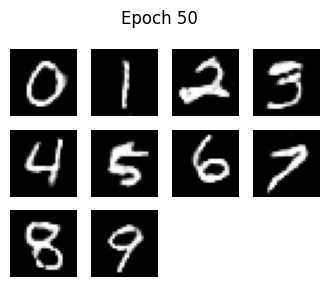

In [7]:
EPOCHS = 50

num_examples_to_generate = NUM_CLASSES
# Создаем шум и метки
seed = tf.random.normal([NUM_CLASSES, NOISE_DIM])
seed_labels = tf.convert_to_tensor([i for i in range(NUM_CLASSES)], dtype=tf.int32)  

def generate_and_save_images(model, epoch, test_input, test_labels):
    test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)
    
    # Генерация изображений
    predictions = model([test_input, test_labels], training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

# Обучающий шаг
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    generated_labels = tf.random.uniform([BATCH_SIZE, 1], minval=0, maxval=NUM_CLASSES, dtype=tf.int32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, generated_labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, generated_labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Цикл обучения
def train(dataset, epochs, start_epoch=1):
    for epoch in range(start_epoch, epochs + 1):
        start = time.time()

        # Прогресс-бар для текущей эпохи
        pbar = tqdm(enumerate(dataset), total=len(dataset), desc=f'Epoch {epoch}/{epochs}', unit='batch')

        gen_loss_list = []
        disc_loss_list = []

        for batch_num, (image_batch, label_batch) in pbar:
            g_loss, d_loss = train_step(image_batch, label_batch)
            gen_loss_list.append(g_loss)
            disc_loss_list.append(d_loss)

            pbar.set_description(f"Epoch {epoch}/{epochs}, Batch {batch_num+1}/{len(dataset)}, Gen Loss: {g_loss:.4f}, Disc Loss: {d_loss:.4f}")
            pbar.refresh()

        # Средние потери за эпоху
        gen_loss_avg = np.mean(gen_loss_list)
        disc_loss_avg = np.mean(disc_loss_list)

        print(f'Epoch {epoch} завершена. Средняя потеря Генератора: {gen_loss_avg:.4f}, Средняя потеря Дискриминатора: {disc_loss_avg:.4f}. Время: {time.time()-start:.2f} сек')

        generator.save(os.path.join(CHECKPOINT_DIR, f'generator_epoch_{epoch}.h5'))
        discriminator.save(os.path.join(CHECKPOINT_DIR, f'discriminator_epoch_{epoch}.h5'))

        if (epoch % 10 == 0) or (epoch == 1):
            generate_and_save_images(generator, epoch, seed, seed_labels)
    
    # Генерация после последней эпохи
    generate_and_save_images(generator, epochs, seed, seed_labels)

train(train_dataset, EPOCHS, start_epoch=start_epoch)

После обучения модели можно генерировать изображения рукописных цифр, задавая нужный класс.

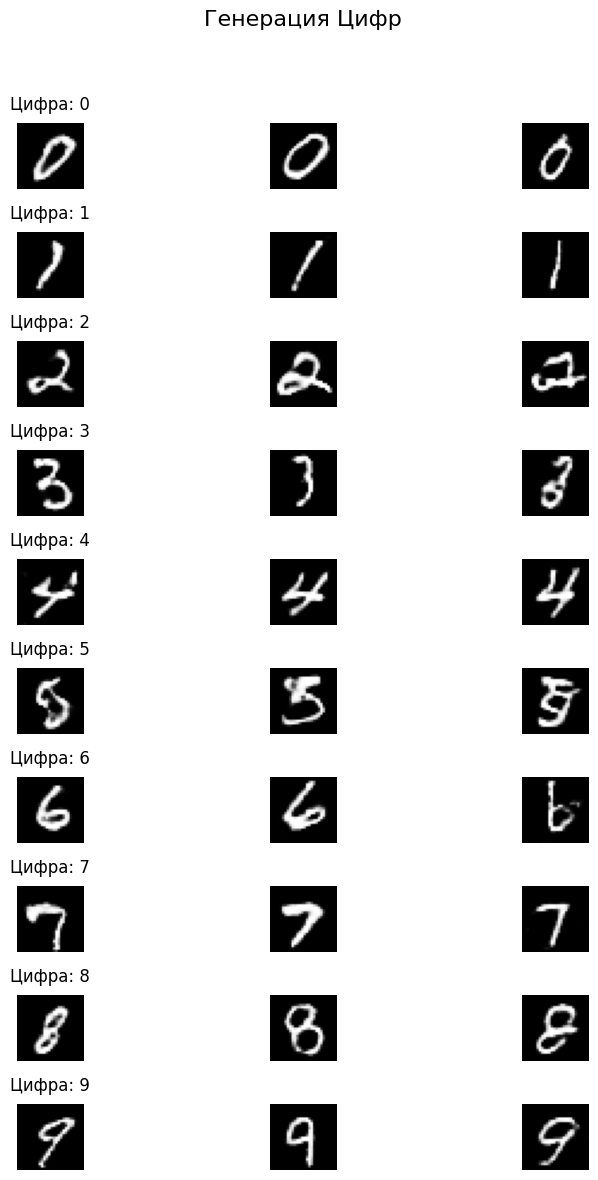

In [10]:
def generate_images_table(generator, noise_dim):
    fig, axes = plt.subplots(10, 3, figsize=(9, 12))
    fig.suptitle("Генерация Цифр", fontsize=16)
    
    for digit in range(10):
        for i in range(3): 
            noise = tf.random.normal([1, noise_dim])
            label = tf.convert_to_tensor([[digit]], dtype=tf.int32)
            
            generated_image = generator([noise, label], training=False)
            generated_image = generated_image[0, :, :, 0] * 127.5 + 127.5 
            
            ax = axes[digit, i]
            ax.imshow(generated_image, cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Цифра: {digit}', fontsize=12, pad=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

generate_images_table(generator, NOISE_DIM)

### Итог

Реализован условный GAN для генерации рукописных цифр из датасета MNIST. Модель позволяет генерировать изображения определенного класса.